In [1]:
import os
import sys
import math
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

%matplotlib notebook
sys.path.append("lib") # go to parent dir
import pickle

import subprocess
import nibabel
import PIL.Image as Image

import lib.motion as motion
import lib.head_motion
import lib.models as models

W1114 16:03:16.615812 140082958034688 deprecation_wrapper.py:119] From /data/vision/polina/scratch/nmsingh/dev/Motion-Experiments/lib/models.py:4: The name tf.keras.layers.CuDNNGRU is deprecated. Please use tf.compat.v1.keras.layers.CuDNNGRU instead.

W1114 16:03:16.616942 140082958034688 deprecation_wrapper.py:119] From /data/vision/polina/scratch/nmsingh/dev/Motion-Experiments/lib/models.py:4: The name tf.keras.layers.CuDNNLSTM is deprecated. Please use tf.compat.v1.keras.layers.CuDNNLSTM instead.

Using TensorFlow backend.


In [2]:
n = 64
num_lines = None
batch_size = 8

# Set up model
model = models.get_theta_k_model((n,n,2),single=True)
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights

training_dir = 'training/ismrm/BRAIN-ALL-CONTIGUOUS-PATCHFalse-PARAMETERIZED_SINGLE_THETA-relu-FREQUENCY_INDOMAIN-SINGLE_THETA_K_OUTDOMAIN-False-5000epoch-64-*single_theta_k_256/'
model.load_weights(training_dir+'cp-0460.ckpt')

W1114 16:03:17.649260 140082958034688 deprecation.py:506] From /data/vision/polina/scratch/nmsingh/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [3]:
def fftshift2(tensor):
    # Assumes input tensor of size: (height,width)
    shape = tensor.get_shape().as_list()
    N = shape[0]
    half = int(N/2)
    x_shifted_tensor = tf.concat([tensor[half:,:],tensor[:half,:]],axis=0)
    shifted_tensor = tf.concat([x_shifted_tensor[:,half:],x_shifted_tensor[:,:half]],axis=1)
    return shifted_tensor

def fftshift(tensor,axis):
    # Assumes input tensor of size: (height,width)
    shape = tensor.get_shape().as_list()
    N = shape[0]
    half = int(N/2)
    if(axis==0):
        shifted_tensor = tf.concat([tensor[half:,:],tensor[:half,:]],axis=0)
    else:
        shifted_tensor = tf.concat([tensor[:,half:],tensor[:,:half]],axis=1)
    return shifted_tensor

In [4]:
img_dir = '/data/vision/polina/scratch/nmsingh/ADNI-data/uncropped/adni-split-by-subj-slice128-axial/train/origs/'
imgs = os.listdir(img_dir)

def get_figs(i):

    img = np.load(img_dir+imgs[i])
    img = np.rot90(img['vol_data'])
    n = 64
    sl_data = np.array(Image.fromarray(img).resize((n,n)))
    sl_data = sl_data - sl_data.mean()
    sl_data = sl_data/np.max(sl_data)

    n = 64
    k_line = np.random.randint(0,n)
    k_vect = np.zeros(n)

    k_line = 45#np.random.randint(0,n)
    k_vect[k_line] = 1

    num_pix = np.zeros((n,2))
    num_pix[k_line:,0] = np.random.random()*20-10
    num_pix[k_line:,1] = np.random.random()*20-10
    angle = np.zeros(n)
    angle[k_line:] = np.random.random()*90-45

    corrupted_img,corrupted_k = motion.add_rotation_and_translation(sl_data,angle,num_pix,return_k=True)
    corrupted_k = np.expand_dims(corrupted_k,-1)
    corrupted_k_re = np.real(corrupted_k)
    corrupted_k_im = np.imag(corrupted_k)
    corrupted_k = np.concatenate([corrupted_k_re,corrupted_k_im], axis=2)

    true_outputs = np.expand_dims(np.array([num_pix[-1,0],num_pix[-1,1],angle[-1],np.array(k_line)]),axis=0)
    network_input = corrupted_k
    
    n = 64
    num_lines = None
    batch_size = 8

    # Set up model
    model = models.get_theta_k_model((n,n,2),single=True)
    model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
            loss='mean_squared_error',
            metrics=[keras.metrics.mae])

    # Load trained model weights
    training_dir = 'training/ismrm/BRAIN-ALL-CONTIGUOUS-PATCHFalse-PARAMETERIZED_SINGLE_THETA-relu-FREQUENCY_INDOMAIN-SINGLE_THETA_K_OUTDOMAIN-False-5000epoch-64-*single_theta_k_256/'
    model.load_weights(training_dir+'cp-0500.ckpt')
    
    model_out = -1*model.predict(np.expand_dims(network_input,0))
    input_copy = network_input.copy()
    input_copy[:k_line]=0
    
    # FFT-Translate
    fft_input = input_copy
    shift = [model_out[0][0][0],model_out[0][0][1]]
    N = fft_input.shape[0]
    complex_input = tf.dtypes.cast(fft_input[:,:,0],'complex64')+1j*tf.dtypes.cast(fft_input[:,:,1],'complex64')

    col = np.expand_dims(np.arange(N),0)
    cols = tf.convert_to_tensor(np.fft.fftshift(np.repeat(col,N,axis=0)),dtype='float32')
    cols_exponent = 2*math.pi*1j*tf.dtypes.cast(tf.math.scalar_mul(tf.math.divide(shift[0],N),cols),'complex64')
    cols_exp = tf.math.exp(cols_exponent)

    row = np.expand_dims(np.arange(N),-1)
    rows = tf.convert_to_tensor(np.fft.fftshift(np.repeat(row,N,axis=1)),dtype='float32')
    rows_exponent = 2*math.pi*1j*tf.dtypes.cast(tf.math.scalar_mul(tf.math.divide(shift[1],N),rows),'complex64')
    rows_exp = tf.math.exp(rows_exponent)

    combined_exp = tf.math.multiply(rows_exp,cols_exp)
    output = tf.math.multiply(tf.dtypes.cast(complex_input,'complex64'),combined_exp)

    # FFT-Rotate
    fft_input = output
    theta = model_out[0][0][2]

    N = fft_input.get_shape().as_list()[0]

    x_shift = tf.cast(tf.math.tan(theta/2),dtype='float32')
    y_shift = tf.cast(-tf.math.sin(theta),dtype='float32')
    img_tensor = tf.signal.ifft2d(fftshift2(fft_input)) # fine here

    row = np.expand_dims(np.arange(N),-1)-32
    rows = tf.convert_to_tensor(np.repeat(row,N,axis=1),dtype='float32')

    col = np.expand_dims(np.arange(N),0)-32
    cols = tf.convert_to_tensor(np.repeat(col,N,axis=0),dtype='float32') # fine here

    prod_x = rows*cols*x_shift
    prod_exponent_x = -2*math.pi*1j*tf.dtypes.cast(prod_x,'complex64')/N
    prod_exp_x = tf.math.exp(prod_exponent_x) 

    img_xfft = fftshift(tf.signal.fft(img_tensor),axis=1)
    x_img_shift = tf.signal.ifft(fftshift(img_xfft*prod_exp_x,axis=1))

    prod_y = rows*cols*y_shift
    prod_exponent_y = -2*math.pi*1j*tf.dtypes.cast(prod_y,'complex64')/N
    prod_exp_y = tf.math.exp(prod_exponent_y)

    x_img_shift_swapaxes = tf.transpose(x_img_shift,[1,0])
    img_xyfft = fftshift(tf.signal.fft(x_img_shift_swapaxes),axis=1)
    xy_img_shift_swapaxes = tf.signal.ifft(fftshift(img_xyfft*prod_exp_y,axis=1))
    xy_img_shift = tf.transpose(xy_img_shift_swapaxes,[1,0])

    img_xyxfft = fftshift(tf.signal.fft(xy_img_shift),axis=1)
    rot_img = tf.signal.ifft(fftshift(img_xyxfft*prod_exp_x,axis=1))

    rot_fft = fftshift2(tf.signal.fft2d(rot_img))
    
    with tf.Session().as_default() as default_session:
        adjusted = rot_fft.eval()
        
    adjusted.shape
    adjusted_re = np.expand_dims(np.real(adjusted),-1)
    adjusted_im = np.expand_dims(np.imag(adjusted),-1)
    adjusted_compl = np.concatenate([adjusted_re,adjusted_im],axis=2)
    
    # Combine data
    combined = np.zeros((64,64,2))
    combined[:k_line,:,:] = network_input[:k_line,:,:]
    combined[k_line:,:,:] = adjusted_compl[k_line:,:,:]
    combined_img = np.fft.ifft2(np.fft.ifftshift(combined[:,:,0]+1j*combined[:,:,1]))
    
    return sl_data,corrupted_img,combined_img, np.fft.fftshift(np.fft.fft2(sl_data)), combined

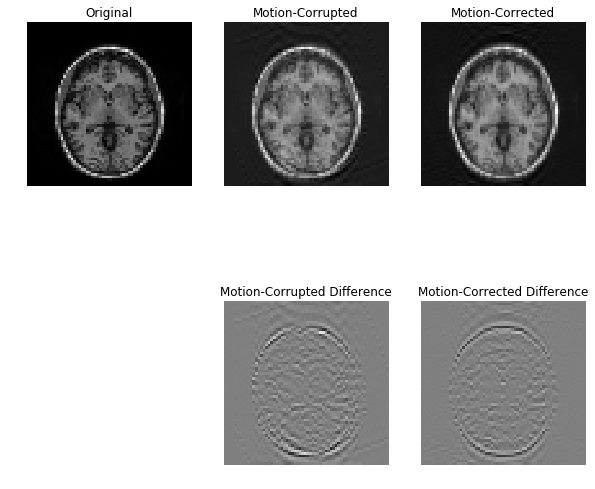

In [5]:
i = 0

img, corrupted_img, combined_img, true_k, combined_k = get_figs(i)
fig, axes = plt.subplots(2, 3, figsize=(10,10))
axes[0][0].imshow(np.real(img),cmap='gray')
axes[0][0].axis('off')
axes[0][0].set_title('Original')
fig.delaxes(axes[1][0])

axes[0][1].imshow(np.real(corrupted_img),cmap='gray')
axes[0][1].axis('off')
axes[0][1].set_title('Motion-Corrupted')

axes[1][1].imshow(np.real(corrupted_img-img),cmap='gray',vmin=-0.4,vmax=0.4)
axes[1][1].axis('off')
axes[1][1].set_title('Motion-Corrupted Difference')

axes[0][2].imshow(np.real(combined_img),cmap='gray')
axes[0][2].axis('off')
axes[0][2].set_title('Motion-Corrected')

axes[1][2].imshow(np.real(combined_img-img),cmap='gray',vmin=-0.4,vmax=0.4)
axes[1][2].axis('off')
axes[1][2].set_title('Motion-Corrected Difference')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.05)
